In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Han', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 12444.12 seconds 
duration: 3.46 hours 



## Save notebook to animal working directory

In [5]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Han_training_Han_training_Sync_USV_and_Ephys.ipynb saved to /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training_Han_training_Han_training_Sync_USV_and_Ephys.ipynb


### Load in disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 109.1 seconds


,start,stop,label,duration
0,159.7436,170.1324,None,10.3888
1,408.2588,417.1892,None,8.9304
2,859.7700,861.2836,None,1.5136
3,1131.6012,1133.1612,None,1.5600
4,1388.3636,1389.8148,None,1.4512
5,1428.2516,1440.1052,None,11.8536
6,1606.8492,1608.3668,None,1.5176
7,1857.1372,1858.7028,None,1.5656
8,2132.0428,2133.4652,None,1.4224
9,2508.8548,2516.5156,None,7.6608


<Axes: >

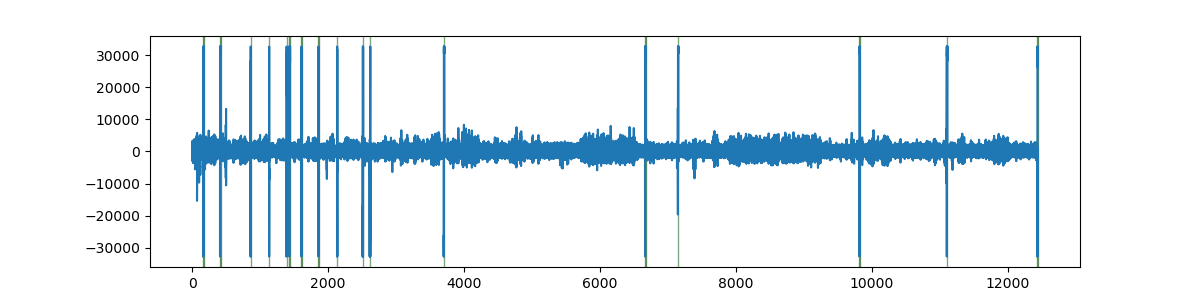

In [7]:
%matplotlib widget

chan_plot = 6
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.probegroup.npy saved


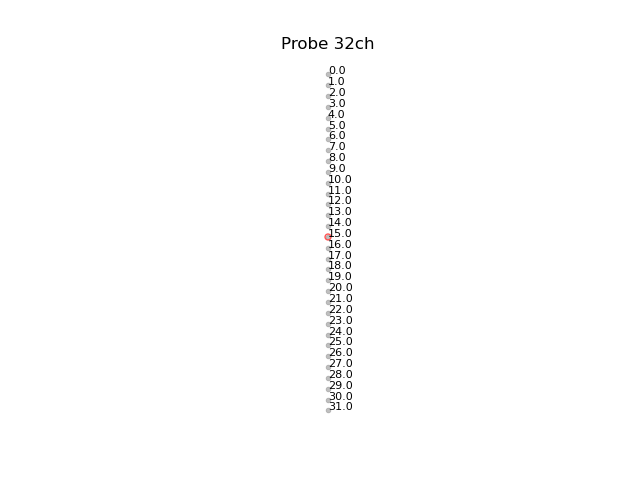

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [9]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 6

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [6]
930 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [10]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 6
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [6]
7450 epochs remaining with durations within (0.05,0.45)


## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
615,2,2376226,2022-08-03 12:26:48.207533333,
716,-2,2673758,2022-08-03 12:26:58.125266667,
1234,2,4226403,2022-08-03 12:27:49.880100000,
1335,-2,4524446,2022-08-03 12:27:59.814866667,
93,2,279173,2022-08-03 12:28:59.305766667,


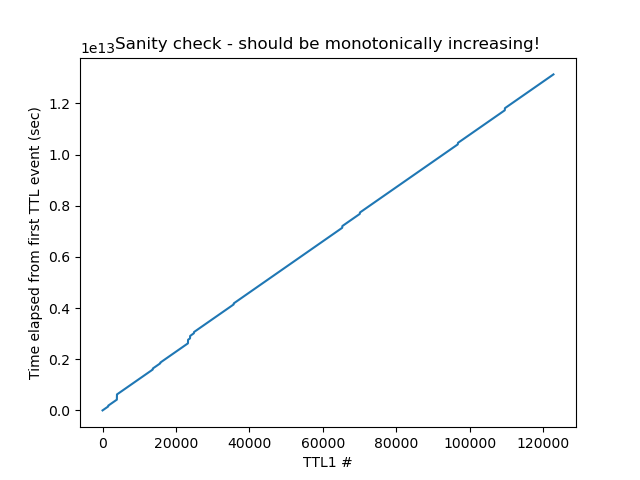

In [11]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [12]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

5 CS- events detected
      Time (s)      Event                     Timestamp
5    61.611391  CS1_start 2022-08-03 12:26:48.547290068
7   123.284284  CS2_start 2022-08-03 12:27:50.220183353
9   193.079082  CS3_start 2022-08-03 12:29:00.014981489
11  273.033481  CS4_start 2022-08-03 12:30:19.969380121
13  344.838630  CS5_start 2022-08-03 12:31:31.774529438
6 CS+ events detected
       Time (s)      Event                     Timestamp
10   365.884472  CS1_start 2022-08-03 12:42:14.453900370
20   637.729703  CS2_start 2022-08-03 12:46:46.299130950
30   894.384018  CS3_start 2022-08-03 12:51:02.953446421
40  1150.995409  CS4_start 2022-08-03 12:55:19.564837250
50  1417.781024  CS5_start 2022-08-03 12:59:46.350451502
60  1692.700537  CS6_start 2022-08-03 13:04:21.269964728


In [13]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-08-03 12:25:29.361157-04:00
start time = 2022-08-03 12:28:50.720333-04:00
start time = 2022-08-03 12:35:21.719327-04:00
start time = 2022-08-03 12:53:02.683128-04:00
start time = 2022-08-03 12:56:48.234187-04:00
start time = 2022-08-03 13:10:55.680961-04:00
start time = 2022-08-03 13:14:13.174881-04:00
start time = 2022-08-03 13:16:44.696588-04:00
start time = 2022-08-03 13:35:23.930035-04:00
start time = 2022-08-03 14:25:45.955674-04:00
start time = 2022-08-03 14:34:34.738770-04:00
start time = 2022-08-03 15:19:53.342091-04:00
start time = 2022-08-03 15:42:32.218764-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-08-03 12:25:29.361157-04:00,start,0,0.000000,0,0.0000
1,0,2022-08-03 12:28:19.242723667-04:00,stop,5096447,169.881567,212351,169.8808
2,1,2022-08-03 12:28:50.720333-04:00,start,5096448,169.881600,212352,169.8816
3,1,2022-08-03 12:32:57.777366333-04:00,stop,12508159,416.938633,521173,416.9384
4,2,2022-08-03 12:35:21.719327-04:00,start,12508160,416.938667,521174,416.9392
5,2,2022-08-03 12:52:24.635560333-04:00,stop,43195647,1439.854900,1799818,1439.8544
6,3,2022-08-03 12:53:02.683128-04:00,start,43195648,1439.854933,1799819,1439.8552
7,3,2022-08-03 12:56:31.765494667-04:00,stop,49468119,1648.937300,2061171,1648.9368
8,4,2022-08-03 12:56:48.234187-04:00,start,49468120,1648.937333,2061172,1648.9376
9,4,2022-08-03 13:09:30.277887-04:00,stop,72329431,2410.981033,3013726,2410.9808


In [42]:
np.diff(cs_starts['Time (s)'])

array([271.84523058, 256.65431547, 256.61139083, 266.78561425,
       274.91951323])

In [14]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.5394885366666666, std = 0.2466135352632615
start time lag: mean = -0.539772271, std = 0.24672374012407294
start time lag: mean = -0.561666227, std = 0.20242577000755455
start time lag: mean = -0.5619773967999999, std = 0.20256404992101418


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


In [43]:
cs_starts

,Time (s),Event,Timestamp
10,365.884472,CS1_start,2022-08-03 12:42:14.453900370
20,637.729703,CS2_start,2022-08-03 12:46:46.299130950
30,894.384018,CS3_start,2022-08-03 12:51:02.953446421
40,1150.995409,CS4_start,2022-08-03 12:55:19.564837250
50,1417.781024,CS5_start,2022-08-03 12:59:46.350451502
60,1692.700537,CS6_start,2022-08-03 13:04:21.269964728


In [37]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name
3661,2,12382394,2022-08-03 12:42:13.746466667-04:00,
6383,2,20537723,2022-08-03 12:46:45.590766667-04:00,
8953,2,28237336,2022-08-03 12:51:02.244533333-04:00,
1370,2,4106882,2022-08-03 12:55:18.896066667-04:00,
1729,2,5343876,2022-08-03 12:59:46.129200-04:00,
4481,2,13591433,2022-08-03 13:04:21.047766667-04:00,


### How to write CS+ to neuroscope event file

In [15]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [34]:
print(cs_starts_combined)
np.diff(cs_starts_combined)

[ 828.966339 1100.810639 1357.464406 1576.068138 1826.832613 2101.751179]


array([271.8443  , 256.653767, 218.603732, 250.764475, 274.918566])

In [36]:
print(cs_wav_epochs.starts)
np.diff(cs_wav_epochs.starts)

[ 415.06426966  686.9661236   943.65230337 1200.30370787 1467.12106742
 1742.07168539]


array([271.90185393, 256.68617978, 256.65140449, 266.81735955,
       274.95061798])

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/2_training/shockbox/T0000001.wav
Mean start lag time of 389.452 sec with std = 24.982 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 389.250 sec with std = 24.983 sec.


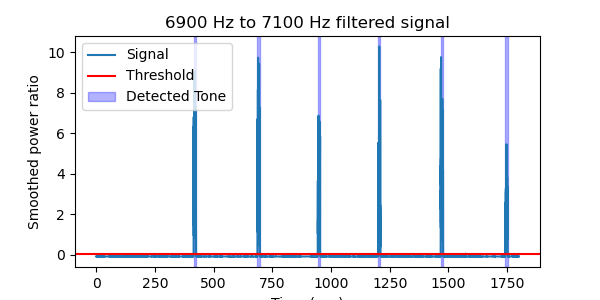

In [16]:
# Detect CS+ in audio recording.
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", plot_check=True)
# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

In [17]:
##var = 2
##print(f"This is my {var}st test")
##print("This is my " + str(var) + "st test")

This is my 2st test
This is my 2st test


/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/1_tone_habituation/tone_habit_box/T0000002.wav
No tones detected at thresh=-0.1 and length=10. Adjust power/time thresholds and re-run


ValueError: operands could not be broadcast together with shapes (5,) (0,) 

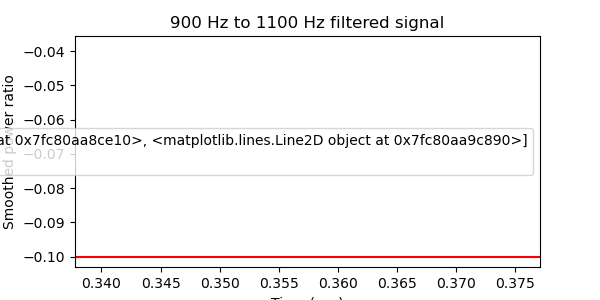

In [18]:
# Detect CS- in audio recording.
csn_wav = grab_usv_folder(sess.basepath, "csn")
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", plot_check=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/3_post/rest_box/T0000003.wav


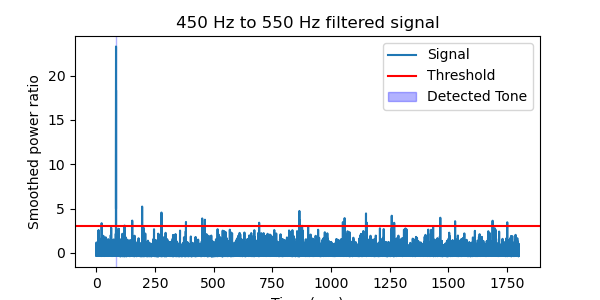

In [23]:
no_tone_wave = grab_usv_folder(sess.basepath, "sync")
print(no_tone_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=3, tone_length=0.5, tone_label="start_tone", plot_check=True)

## Sync recorded USV times to ephys file

In [27]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(Path(csp_wav).parent.glob(f"**/{Path(csp_wav).name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
0,39.364712,38.000,0.030000,28.75,0.565341,0
1,39.794712,38.000,0.020000,28.75,0.565341,0
2,45.494712,38.000,0.030000,28.75,0.565341,0
3,68.634712,38.000,0.060000,28.75,0.565341,0
4,75.474712,38.000,0.010000,28.75,0.565341,0
...,...,...,...,...,...,...
370,1786.513960,19.500,0.060000,47.25,0.568593,0
371,1787.043960,19.500,0.469704,47.25,0.567743,0
372,1793.653664,19.625,0.090000,47.00,0.566894,0
373,1793.863664,19.625,0.420000,47.00,0.566894,0


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

In [29]:
cs_lags_comb

array([[413.90206934, 413.66373184],
       [413.8445154 , 413.63638087],
       [413.81210263, 413.63111836],
       [375.76443013, 375.64575107],
       [359.71154558, 359.47683364],
       [359.67949361, 359.44482956]])

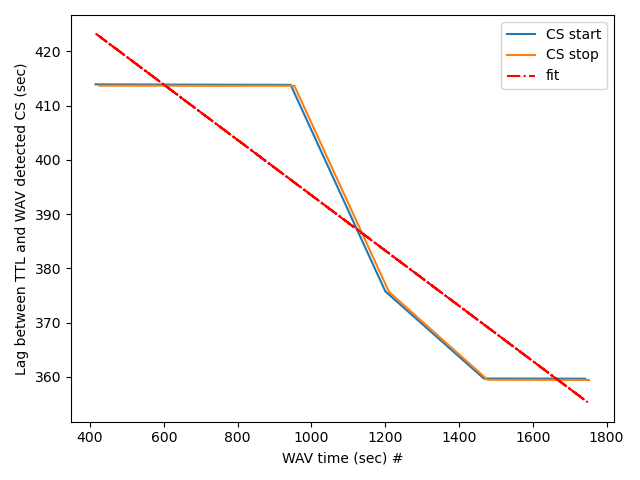

In [28]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [ ]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

In [ ]:
cs_wav_epochs_aligned

Now correct that drift and find corrected lags!

In [ ]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

In [ ]:
good_calls

## Save notebook to working directory

In [ ]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)